## Conceptual overview and comparison of NPQ correction approaches

The following directed acyclic graphs (DAGs) summarize the conceptual assumptions and modeling choices underlying three different approaches to NPQ correction: Lucius et al. (2020), Sharp et al. (2025), and the hierarchical Bayesian model developed in this notebook. The purpose of these DAGs is not to assert full causal identification, but to make explicit how each approach relates observed measurements to latent processes and how those relationships are encoded statistically.

Across all DAGs, **node color and border style carry distinct meanings**. Blue nodes represent observed or directly constructed variables, while gray nodes represent latent or unobserved processes. Solid borders indicate variables that are explicitly used in the statistical model or correction pipeline of the corresponding study, either as predictors, targets, or inferred parameters. Dashed borders indicate variables that are part of the conceptual framework but are not conditioned on or estimated directly.

Directed arrows represent hypothesized generative or causal influences, with arrow direction indicating the assumed direction of influence rather than statistical association. The DAGs therefore serve as interpretive guides that clarify what each approach assumes, what it estimates, and what it intentionally leaves unresolved.

In [ ]:
from graphviz import Digraph

# -----------------------------------------------------------------------------
# Shared styling + node helper (NEW encoding)
#   - Fill color: observed (blue) vs latent (gray)
#   - Border: solid if USED in the paper/model; dashed if NOT used (conceptual only)
# -----------------------------------------------------------------------------
def _init_dot(name: str, graph_label: str, size="8,10"):
    dot = Digraph(name, format="png")
    dot.attr(rankdir="LR", bgcolor="white", size=size, ranksep="0.5", nodesep="0.1")
    dot.attr(label=graph_label, labelloc="t", fontsize="14",
             fontname="Helvetica", fontcolor="black")
    return dot

def add_node(dot: Digraph, node_id: str, label: str, observed: bool = True, used: bool = True):
    """
    observed=True  -> blue fill (measured/constructed)
    observed=False -> gray fill (latent/unobserved/parameter/process)
    used=True      -> SOLID border (used in the modeling/pipeline as predictor/target/parameter)
    used=False     -> DASHED border (not used; conceptual/excluded/background)
    """
    fillcolor = "lightsteelblue" if observed else "lightgray"
    style = "filled,rounded" if used else "filled,rounded,dashed"
    dot.node(
        node_id,
        label,
        shape="rectangle",
        style=style,
        fillcolor=fillcolor,
        color="black",
        fontname="Helvetica",
        fontcolor="black",
    )



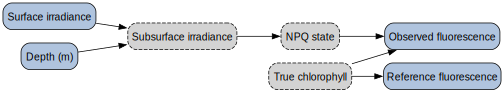

In [6]:
def plot_npq_conceptual_dag():
    dot = Digraph("NPQ_Conceptual_DAG", format="png")
    dot.attr(rankdir="LR", bgcolor="white", size="7,5", ranksep="0.6")

    # ---- Node styles ----
    # Observed variables: blue, solid
    def obs(nid, label):
        dot.node(
            nid, label,
            shape="rectangle",
            style="filled,rounded",
            fillcolor="lightsteelblue",
            color="black",
            fontcolor="black",
            fontname="Helvetica",
        )

    # Latent variables: gray, dashed
    def latent(nid, label):
        dot.node(
            nid, label,
            shape="rectangle",
            style="filled,rounded,dashed",
            fillcolor="lightgray",
            color="black",
            fontcolor="black",
            fontname="Helvetica",
        )

    # ---- Observed context / forcing ----
    obs("SurfaceLight", "Surface irradiance")
    obs("Depth", "Depth (m)")
    obs("F_obs", "Observed fluorescence")
    obs("F_ref", "Reference fluorescence")

    # ---- Latent processes ----
    latent("E_sub", "Subsurface irradiance")
    latent("NPQ", "NPQ state")
    latent("Chl_true", "True chlorophyll")

    # ---- Edges: physics ----
    dot.edge("SurfaceLight", "E_sub")
    dot.edge("Depth", "E_sub")

    # ---- Edges: physiology ----
    dot.edge("E_sub", "NPQ")

    # ---- Edges: measurement ----
    dot.edge("Chl_true", "F_obs")
    dot.edge("NPQ", "F_obs")
    dot.edge("Chl_true", "F_ref")

    # ---- Rank hints for layout ----
    with dot.subgraph() as s:
        s.attr(rank="same")
        s.node("SurfaceLight")
        s.node("Depth")

    with dot.subgraph() as s:
        s.attr(rank="same")
        s.node("E_sub")

    with dot.subgraph() as s:
        s.attr(rank="same")
        s.node("NPQ")
        s.node("Chl_true")

    with dot.subgraph() as s:
        s.attr(rank="same")
        s.node("F_obs")
        s.node("F_ref")

    return dot


dot = plot_npq_conceptual_dag()
dot.render("npq_conceptual_dag", cleanup=True, view=True, directory="../figures")
dot


In [ ]:

# -----------------------------------------------------------------------------
# 1) Lucius et al. (2020) DAG (Predictors -> NPQ% -> correction application)
#   USED predictors (per paper): raw Fchl, Et, depth, month, water temp,
#   1-hr avg Et, DO_sat, solar azimuth. Target: NPQ%.
# -----------------------------------------------------------------------------
def plot_dag_lucius_2020():
    dot = _init_dot("DAG_LUCIUS_2020", "Lucius et al. (2020): Predictors → NPQ%")

    # Observed predictors / context
    add_node(dot, "F_chl", "Fchl (raw fluorescence)", observed=True, used=True)
    add_node(dot, "Et", "Et (surface solar radiation)", observed=True, used=True)
    add_node(dot, "Et_1hr", "Et_1hr_avg", observed=True, used=True)
    add_node(dot, "Depth", "Depth (m)", observed=True, used=True)
    add_node(dot, "Month", "Month", observed=True, used=True)
    add_node(dot, "Water_temp", "Water temp (°C)", observed=True, used=True)
    add_node(dot, "DO_sat", "DO_sat (%)", observed=True, used=True)
    add_node(dot, "Solar_azimuth", "Solar_azimuth", observed=True, used=True)

    # Observed but not used in Lucius model (kept conceptual here)
    add_node(dot, "Site", "Site", observed=True, used=False)
    add_node(dot, "F_corr", "Corrected fluorescence\n(application step)", observed=True, used=False)

    # Target
    add_node(dot, "NPQ_pct", "NPQ% (model target)", observed=True, used=True)

    # Latent / conceptual nodes (not used explicitly)
    add_node(dot, "NPQ_state", "NPQ_state (latent)", observed=False, used=False)
    add_node(dot, "Chla_true", "Chla_true (latent)", observed=False, used=False)
    add_node(dot, "Phys", "Physiology / light history\n(unobserved)", observed=False, used=False)
    add_node(dot, "Sensor_bias", "Sensor_bias / drift", observed=False, used=False)

    # Conceptual forcing and measurement relations
    dot.edge("Month", "Et")
    dot.edge("Solar_azimuth", "Et")
    dot.edge("Et", "Et_1hr")

    dot.edge("Et", "NPQ_state")
    dot.edge("Et_1hr", "NPQ_state", label="light history proxy")
    dot.edge("Water_temp", "NPQ_state")
    dot.edge("Depth", "NPQ_state")
    dot.edge("Phys", "NPQ_state")

    dot.edge("Chla_true", "F_chl")
    dot.edge("NPQ_state", "F_chl", label="suppresses yield")
    dot.edge("Sensor_bias", "F_chl")

    dot.edge("Chla_true", "DO_sat")
    dot.edge("Et", "DO_sat")
    dot.edge("Water_temp", "DO_sat")

    # Statistical model (predictors -> NPQ%)
    dot.edge("F_chl", "NPQ_pct")
    dot.edge("Et", "NPQ_pct")
    dot.edge("Et_1hr", "NPQ_pct")
    dot.edge("Depth", "NPQ_pct")
    dot.edge("Month", "NPQ_pct")
    dot.edge("Water_temp", "NPQ_pct")
    dot.edge("DO_sat", "NPQ_pct")
    dot.edge("Solar_azimuth", "NPQ_pct")

    # Application (not part of model fitting)
    dot.edge("NPQ_pct", "F_corr", label="used to correct")
    dot.edge("F_chl", "F_corr")

    # Rank hints
    with dot.subgraph() as s:
        s.attr(rank="same")
        for nid in ["Site", "Month", "Solar_azimuth", "Water_temp", "Depth"]:
            s.node(nid)

    with dot.subgraph() as s:
        s.attr(rank="same")
        for nid in ["Et", "Et_1hr"]:
            s.node(nid)

    with dot.subgraph() as s:
        s.attr(rank="same")
        for nid in ["Chla_true", "NPQ_state", "Phys", "Sensor_bias"]:
            s.node(nid)

    with dot.subgraph() as s:
        s.attr(rank="same")
        for nid in ["F_chl", "DO_sat", "NPQ_pct", "F_corr"]:
            s.node(nid)

    return dot


# -----------------------------------------------------------------------------
# 2) Sharp et al. (2025) DAG (PAR-driven exp(a·PAR) correction factor)
#   USED: I0, Secchi -> ke, Depth -> I(z) -> PAR; fluorescence -> fChla;
#         Chla_bar -> a_univ -> a; CF=exp(a·PAR); Chla_corr output.
# -----------------------------------------------------------------------------
def plot_dag_sharp_2025():
    dot = _init_dot("DAG_SHARP_2025", "Sharp et al. (2025): PAR-driven correction factor exp(a·PAR)")

    # Observed inputs / derived used in pipeline
    add_node(dot, "I0", "Incoming shortwave (I0)", observed=True, used=True)
    add_node(dot, "Secchi", "Secchi depth (m)", observed=True, used=True)
    add_node(dot, "Depth", "Depth (m)", observed=True, used=True)
    add_node(dot, "Water_temp", "Water temp (°C)", observed=True, used=True)
    add_node(dot, "F_meas", "Measured fluorescence (RFU)", observed=True, used=True)

    add_node(dot, "ke", "Extinction ke = 1.8 / Secchi", observed=True, used=True)
    add_node(dot, "I_z", "I(z) = I0·exp(-ke·z)", observed=True, used=True)
    add_node(dot, "PAR", "PAR ≈ 0.47·I(z)", observed=True, used=True)

    add_node(dot, "fChla", "Uncorrected Chl-a (fChla)", observed=True, used=True)
    add_node(dot, "Chla_bar", "Mean uncorrected Chl-a\n(dataset average)", observed=True, used=True)

    add_node(dot, "CF", "Correction factor\nCF = exp(a·PAR)", observed=True, used=True)
    add_node(dot, "Chla_corr", "NPQ-corrected Chl-a (Chla)", observed=True, used=True)

    # Observed but not used (conceptual only)
    add_node(dot, "Site", "Site", observed=True, used=False)

    # Latent / parameter nodes
    add_node(dot, "a_univ", "Universal a\n(from mean Chl-a relation)", observed=False, used=True)
    add_node(dot, "a", "NPQ scalar a\n(dataset-specific)", observed=False, used=True)

    # Latent conceptual nodes not explicitly used
    add_node(dot, "NPQ_state", "NPQ_state (latent)", observed=False, used=False)
    add_node(dot, "K_d", "Optics / attenuation\n(implicit)", observed=False, used=False)
    add_node(dot, "Sensor_bias", "Sensor_bias / drift", observed=False, used=False)

    # PAR derivation chain
    dot.edge("Secchi", "ke")
    dot.edge("K_d", "ke")
    dot.edge("I0", "I_z")
    dot.edge("ke", "I_z")
    dot.edge("Depth", "I_z")
    dot.edge("I_z", "PAR")

    # Conceptual physiology
    dot.edge("PAR", "NPQ_state")
    dot.edge("Water_temp", "NPQ_state")
    dot.edge("Site", "NPQ_state")

    # Fluorescence -> uncorrected chlorophyll
    dot.edge("F_meas", "fChla", label="RFU→Chl-a fit")
    dot.edge("Sensor_bias", "F_meas")
    dot.edge("Sensor_bias", "fChla")

    # Universal a estimation
    dot.edge("fChla", "Chla_bar", label="average")
    dot.edge("Chla_bar", "a_univ", label="log-linear")
    dot.edge("a_univ", "a")

    # Correction factor and corrected Chl-a
    dot.edge("a", "CF")
    dot.edge("PAR", "CF")
    dot.edge("fChla", "Chla_corr")
    dot.edge("CF", "Chla_corr", label="multiplies")

    # Rank hints
    with dot.subgraph() as s:
        s.attr(rank="same")
        for nid in ["Site", "I0", "Secchi", "Depth", "Water_temp", "F_meas"]:
            s.node(nid)

    with dot.subgraph() as s:
        s.attr(rank="same")
        for nid in ["ke", "I_z", "PAR"]:
            s.node(nid)

    with dot.subgraph() as s:
        s.attr(rank="same")
        for nid in ["fChla", "Chla_bar", "a_univ", "a", "CF", "Chla_corr"]:
            s.node(nid)

    with dot.subgraph() as s:
        s.attr(rank="same")
        for nid in ["NPQ_state", "K_d", "Sensor_bias"]:
            s.node(nid)

    return dot


# -----------------------------------------------------------------------------
# 3) Our Lake George Bayesian model DAG (what we did)
#   USED: Site, Depth, Water_temp, Subsurface irradiance, target δ.
#   Latent used: f(I_sub), μ, Student-t noise params (σ, ν) and hierarchy params.
#   Conceptual latents (NPQ_state, Chla_true, etc.) are NOT explicitly modeled.
# -----------------------------------------------------------------------------
def plot_dag_our_model():
    dot = _init_dot("DAG_OUR_MODEL", "This notebook: Hierarchical Bayesian NPQ correction δ with spline f(I_sub)")

    # Observed inputs used
    add_node(dot, "Site", "Site", observed=True, used=True)
    add_node(dot, "Depth", "Depth (m)", observed=True, used=True)
    add_node(dot, "Water_temp", "Water temp (°C)", observed=True, used=True)
    add_node(dot, "E_sub", "Subsurface_total_radiation", observed=True, used=True)

    # Observed outcomes used to construct target
    add_node(dot, "F_chl", "Fchl (fluorescence)", observed=True, used=True)
    add_node(dot, "F_ref", "Fchl_Reference", observed=True, used=True)

    # Target used
    add_node(dot, "delta", "δ = Fchl_Reference − Fchl\n(model target)", observed=True, used=True)

    # Latent/derived USED in model
    add_node(dot, "fI", "f(I_sub)\n(spline on log1p irradiance)", observed=False, used=True)
    add_node(dot, "mu", "μ (mean model)\nα0 + α_site + (γ0+γ_site)·fI + βT·T + βZ·Z", observed=False, used=True)
    add_node(dot, "Noise", "Student-t likelihood\n(σ, ν)", observed=False, used=True)

    # Latent conceptual nodes NOT explicitly modeled
    add_node(dot, "NPQ_state", "NPQ_state (latent)", observed=False, used=False)
    add_node(dot, "Chla_true", "Chla_true", observed=False, used=False)
    add_node(dot, "Phys", "Physiology / light history\n(unobserved)", observed=False, used=False)
    add_node(dot, "Sensor_bias", "Sensor_bias / drift", observed=False, used=False)

    # Conceptual measurement relations
    dot.edge("E_sub", "NPQ_state")
    dot.edge("Water_temp", "NPQ_state")
    dot.edge("Phys", "NPQ_state")

    dot.edge("Chla_true", "F_chl")
    dot.edge("NPQ_state", "F_chl", label="suppresses yield")
    dot.edge("Sensor_bias", "F_chl")

    dot.edge("Chla_true", "F_ref", label="low-NPQ proxy")
    dot.edge("Sensor_bias", "F_ref")

    # Target construction
    dot.edge("F_ref", "delta")
    dot.edge("F_chl", "delta")

    # Statistical model
    dot.edge("E_sub", "fI")
    dot.edge("fI", "mu")
    dot.edge("Depth", "mu")
    dot.edge("Water_temp", "mu")
    dot.edge("Site", "mu")
    dot.edge("mu", "delta", label="mean")
    dot.edge("Noise", "delta", label="likelihood")

    # Rank hints
    with dot.subgraph() as s:
        s.attr(rank="same")
        for nid in ["Site", "Depth", "Water_temp"]:
            s.node(nid)

    with dot.subgraph() as s:
        s.attr(rank="same")
        for nid in ["E_sub"]:
            s.node(nid)

    with dot.subgraph() as s:
        s.attr(rank="same")
        for nid in ["Chla_true", "NPQ_state", "Phys", "Sensor_bias"]:
            s.node(nid)

    with dot.subgraph() as s:
        s.attr(rank="same")
        for nid in ["F_chl", "F_ref", "delta"]:
            s.node(nid)

    with dot.subgraph() as s:
        s.attr(rank="same")
        for nid in ["fI", "mu", "Noise"]:
            s.node(nid)

    return dot


# -----------------------------------------------------------------------------
# Render all three (PNG + source)
# -----------------------------------------------------------------------------
dot_lucius = plot_dag_lucius_2020()
dot_lucius.render("dag_lucius_2020_encoded", cleanup=True, view=False)

dot_sharp = plot_dag_sharp_2025()
dot_sharp.render("dag_sharp_2025_encoded", cleanup=True, view=False)

dot_ours = plot_dag_our_model()
dot_ours.render("dag_our_model_encoded", cleanup=True, view=False)


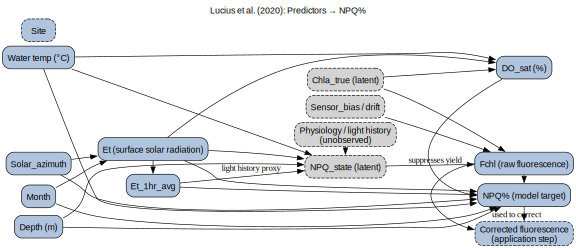

In [3]:
dot_lucius

**DAG A. Conceptual and statistical structure of the Lucius et al. (2020) NPQ correction approach.**  
This DAG illustrates a predictor-driven framework in which NPQ% is modeled directly from a broad set of observed covariates, including raw fluorescence, irradiance metrics, depth, seasonality proxies, temperature, and dissolved oxygen saturation. Many latent biological and physical processes are acknowledged conceptually but are not represented explicitly in the statistical model. The diagram emphasizes that this approach is primarily predictive in nature, relying on correlated environmental and sensor-derived variables to estimate NPQ%, which is then applied as a correction to fluorescence measurements.


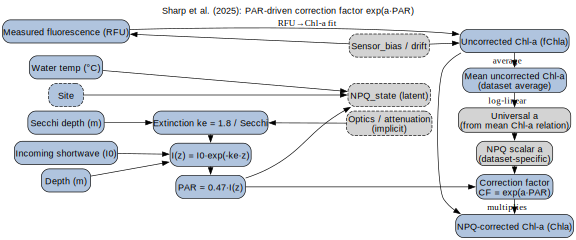

In [4]:
dot_sharp

**DAG B. Conceptual and computational structure of the Sharp et al. (2025) PAR-based correction method.**  
This DAG summarizes a structured correction pipeline in which subsurface photosynthetically active radiation (PAR) is treated as the primary driver of NPQ. PAR is derived deterministically from surface irradiance, optical attenuation, and depth, and is used to compute a multiplicative correction factor through an exponential function. Latent physiological processes are compressed into a small number of parameters, including a dataset-level scalar that is linked empirically to mean uncorrected chlorophyll concentration. The diagram highlights the mechanistic intent of the approach while clarifying which processes are represented implicitly rather than modeled directly.


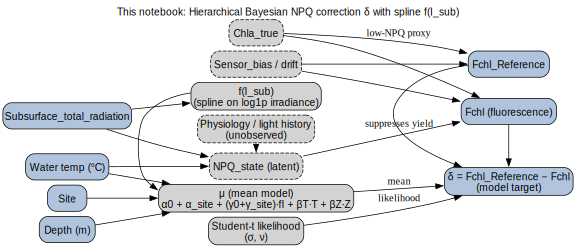

In [5]:
dot_ours

**DAG C. Conceptual and statistical structure of the hierarchical Bayesian NPQ correction model developed in this study.**  
This DAG represents a generative correction framework in which the NPQ correction δ is modeled directly as a function of subsurface irradiance, depth, temperature, and site, with uncertainty propagated explicitly through a hierarchical Bayesian model. A shared nonlinear irradiance response is inferred using a flexible spline, while site-level effects are partially pooled to allow controlled deviations from the population-level behavior. Latent physiological and optical processes are acknowledged but absorbed into latent functions and residual uncertainty rather than modeled explicitly. The diagram emphasizes the distinction between modeled structure and conceptual context, and clarifies how uncertainty is represented at each stage of the correction.
